[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/MulticlassLogistic.ipynb)

# Multiclass Regression

In [1]:
import numpy as np
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn import preprocessing
import random
random.seed(551)

# Simulate toy data

In [2]:
N = 150

X = np.column_stack((np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N),
                     np.random.binomial(1, 0.5, N)))

W_true = np.array([[0,1,0],
                   [0,0,1],
                   [1,0,0],
                   [0,0,1]])

a = np.matmul(X, W_true)
y = np.zeros_like(a)
y[np.arange(len(a)), a.argmax(1)] = 1

In [3]:
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify the fit method to add stop criteria
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()


Split the data into training, validation, and testing

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

Create Multinomial Logistic Regression model object

In [5]:
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

Check gradients

In [6]:
# check grad
print(mlr.check_grad(X_train, y_train))

1.545154206700348e-18


Fitting the multinomial logistic model

iter 0: 58.098; 59.201
iter 1: 55.361; 56.303
iter 2: 52.887; 53.692
iter 3: 50.658; 51.350
iter 4: 48.655; 49.256
iter 5: 46.853; 47.384
iter 6: 45.230; 45.710
iter 7: 43.764; 44.210
iter 8: 42.434; 42.859
iter 9: 41.221; 41.639
iter 10: 40.109; 40.530
iter 11: 39.083; 39.516
iter 12: 38.133; 38.584
iter 13: 37.247; 37.723
iter 14: 36.418; 36.923
iter 15: 35.639; 36.177
iter 16: 34.904; 35.477
iter 17: 34.208; 34.819
iter 18: 33.547; 34.197
iter 19: 32.918; 33.609
iter 20: 32.317; 33.050
iter 21: 31.743; 32.518
iter 22: 31.194; 32.010
iter 23: 30.666; 31.525
iter 24: 30.160; 31.060
iter 25: 29.673; 30.615
iter 26: 29.204; 30.187
iter 27: 28.752; 29.776
iter 28: 28.317; 29.380
iter 29: 27.896; 28.999
iter 30: 27.490; 28.631
iter 31: 27.097; 28.276
iter 32: 26.717; 27.933
iter 33: 26.349; 27.601
iter 34: 25.993; 27.280
iter 35: 25.647; 26.968
iter 36: 25.312; 26.667
iter 37: 24.987; 26.374
iter 38: 24.672; 26.091
iter 39: 24.366; 25.815
iter 40: 24.068; 25.547
iter 41: 23.779; 25.287
it

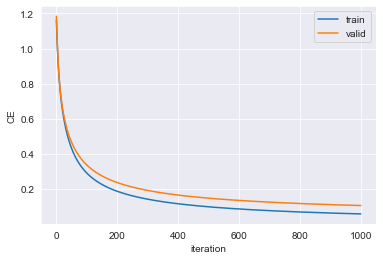

In [7]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.clf()
plt.plot(ce_train/X_train.shape[0], label='train')
plt.plot(ce_valid/X_valid.shape[0], label='valid')
plt.xlabel("iteration")
plt.ylabel("CE")
plt.legend()
# plt.show()
plt.savefig("training_ce.png", bbox_inches="tight", dpi=300)

From the above plot, we can see that the training and validation error curves both continue to decrease. Therefore, there is no sign of overfitting.

In [8]:
def evaluate(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

In [9]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

1.0
1.0
1.0


In [10]:
print(mlr.W)
print(W_true)

[[-0.70310331  4.51715038 -2.01460815]
 [-1.6703352  -1.02360514  3.88221338]
 [ 6.42750539 -3.23123425 -1.05696048]
 [-1.5695338  -0.38289143  3.58898441]]
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]]


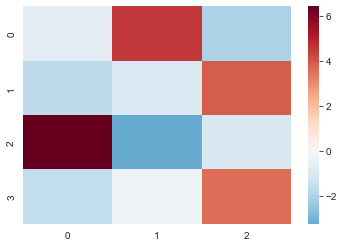

In [11]:
from seaborn import heatmap
W_hat = mlr.W
hmp = heatmap(W_hat, cmap='RdBu_r', center=0)
fig = hmp.get_figure()
fig.savefig("W_hat.png")

Plot as softmax

In [12]:
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=1).reshape(W_hat_transformed.shape[0], 1)
W_hat_transformed

array([[5.36911248e-03, 9.93184372e-01, 1.44651582e-03],
       [3.83430777e-03, 7.32079534e-03, 9.88844897e-01],
       [9.99374783e-01, 6.38250343e-05, 5.61391920e-04],
       [5.61221921e-03, 1.83859831e-02, 9.76001798e-01]])

Now plot the softmax-transformed heatmap, which looks almost identical to groundtruth.

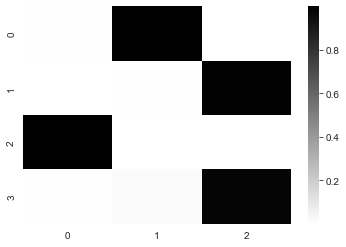

In [13]:
hmp = heatmap(W_hat_transformed, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_hat_transformed.png")

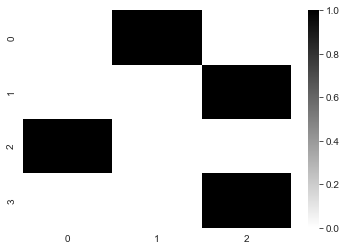

In [14]:
hmp = heatmap(W_true, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("W_true.png")

# Iris flower classification

In [15]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()

print(iris['target_names']) # print flower types
print(iris['feature_names']) # print flower feature names

X = iris.data
y_cat = iris.target

# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

print(y)

['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 

Once again, we split the data into training, testing, and validation

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.66, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

N, C = y_train.shape

X_train = preprocessing.scale(X_train) # standardize input data
X_train = np.c_[X_train, np.ones(N)] # add one column to learn the linear intercept
X_valid = preprocessing.scale(X_valid)
X_valid = np.c_[X_valid, np.ones(X_valid.shape[0])]
X_test = preprocessing.scale(X_test)
X_test = np.c_[X_test, np.ones(X_test.shape[0])]

D = X_train.shape[1]

In [17]:
mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))

1.7548480637468735e-18


iter 0: 25.051; 30.890
iter 1: 22.663; 29.134
iter 2: 20.755; 27.770
iter 3: 19.205; 26.687
iter 4: 17.923; 25.804
iter 5: 16.847; 25.069
iter 6: 15.930; 24.442
iter 7: 15.138; 23.898
iter 8: 14.449; 23.416
iter 9: 13.841; 22.985
iter 10: 13.301; 22.594
iter 11: 12.818; 22.234
iter 12: 12.382; 21.902
iter 13: 11.987; 21.591
iter 14: 11.626; 21.300
iter 15: 11.296; 21.025
iter 16: 10.991; 20.765
iter 17: 10.710; 20.518
iter 18: 10.449; 20.282
iter 19: 10.206; 20.057
iter 20: 9.979; 19.841
iter 21: 9.766; 19.635
iter 22: 9.566; 19.437
iter 23: 9.378; 19.247
iter 24: 9.201; 19.064
iter 25: 9.033; 18.888
iter 26: 8.874; 18.719
iter 27: 8.723; 18.556
iter 28: 8.580; 18.400
iter 29: 8.444; 18.249
iter 30: 8.314; 18.103
iter 31: 8.190; 17.963
iter 32: 8.072; 17.828
iter 33: 7.959; 17.698
iter 34: 7.850; 17.573
iter 35: 7.746; 17.452
iter 36: 7.647; 17.335
iter 37: 7.551; 17.223
iter 38: 7.459; 17.114
iter 39: 7.370; 17.010
iter 40: 7.285; 16.909
iter 41: 7.203; 16.812
iter 42: 7.124; 16.718
i

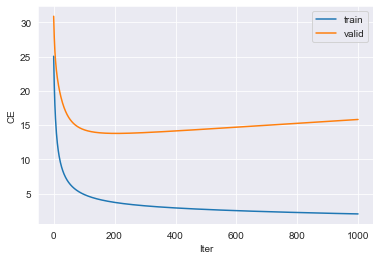

In [18]:
ce_train, ce_valid = mlr.fit(X_train, y_train, X_valid, y_valid, niter=1000)

plt.plot(ce_train, label='train')
plt.plot(ce_valid, label='valid')
plt.legend()
plt.xlabel("Iter")
plt.ylabel("CE")
plt.savefig("iris_training_ce.png", bbox_inches="tight", dpi=300)

In [19]:
mlr = Multinomial_logistic(D, C)
optimal_niter = ce_valid.argmin()
_, _ = mlr.fit(X_train, y_train, niter=optimal_niter) # retrain the model using best niter

iter 0: 24.017
iter 1: 21.581
iter 2: 19.579
iter 3: 17.939
iter 4: 16.593
iter 5: 15.482
iter 6: 14.557
iter 7: 13.779
iter 8: 13.118
iter 9: 12.550
iter 10: 12.057
iter 11: 11.625
iter 12: 11.242
iter 13: 10.901
iter 14: 10.593
iter 15: 10.315
iter 16: 10.061
iter 17: 9.828
iter 18: 9.613
iter 19: 9.414
iter 20: 9.229
iter 21: 9.056
iter 22: 8.894
iter 23: 8.742
iter 24: 8.598
iter 25: 8.463
iter 26: 8.334
iter 27: 8.212
iter 28: 8.095
iter 29: 7.984
iter 30: 7.878
iter 31: 7.777
iter 32: 7.679
iter 33: 7.586
iter 34: 7.496
iter 35: 7.410
iter 36: 7.327
iter 37: 7.247
iter 38: 7.169
iter 39: 7.095
iter 40: 7.022
iter 41: 6.952
iter 42: 6.885
iter 43: 6.819
iter 44: 6.756
iter 45: 6.694
iter 46: 6.634
iter 47: 6.576
iter 48: 6.519
iter 49: 6.464
iter 50: 6.410
iter 51: 6.358
iter 52: 6.307
iter 53: 6.258
iter 54: 6.210
iter 55: 6.163
iter 56: 6.117
iter 57: 6.072
iter 58: 6.028
iter 59: 5.985
iter 60: 5.944
iter 61: 5.903
iter 62: 5.863
iter 63: 5.824
iter 64: 5.785
iter 65: 5.748
ite

Check classification accuracy on training, validation, and testing sets

In [20]:
train_accuracy = evaluate(mlr.predict(X_train), y_train)
valid_accuracy = evaluate(mlr.predict(X_valid), y_valid)
test_accuracy = evaluate(mlr.predict(X_test), y_test)

print(train_accuracy)
print(valid_accuracy)
print(test_accuracy)

0.96
0.8076923076923077
0.6868686868686869


Visualize feature weights for each flower class

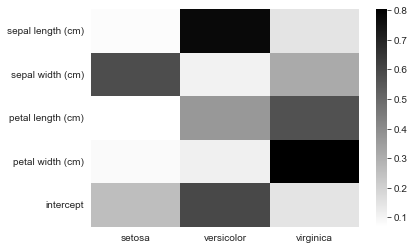

In [21]:
W_hat = mlr.W
W_hat_transformed = np.exp(W_hat)
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=1).reshape(W_hat_transformed.shape[0], 1)

import pandas as pd
iris = datasets.load_iris()
feature_names = iris['feature_names'].copy()
feature_names.append('intercept')
label_names = iris['target_names'].tolist()

W_hat_transformed_df = pd.DataFrame(W_hat_transformed, columns=label_names, index=feature_names)
hmp = heatmap(W_hat_transformed_df, cmap='gray_r')
fig = hmp.get_figure()
fig.savefig("iris_W_hat_transformed.png", bbox_inches="tight", dpi=300)